In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from scipy.optimize import curve_fit
import math

# Surfactant library

In [12]:
surfactant_library = {
    "SDS": {
        "full_name": "Sodium Dodecyl Sulfate",
        "CAS": "151-21-3",
        "CMC": 8.5,
        "Category": "anionic",
        "MW": 289.39,
        "stock_conc": 50,  # mM
        "low": 7,
        "high": 10
    },


    "NaDC": {
        "full_name": "Sodium Docusate",
        "CAS": "577-11-7",
        "CMC": 5.3375,
        "Category": "anionic",
        "MW": 445.57,
        "stock_conc": 25,  # mM
        "low":2.48,
        "high": 8.2
    },

    
    "NaC": {
        "full_name": "Sodium Cholate",
        "CAS": "361-09-1",
        "CMC": 14,
        "Category": "anionic",
        "MW": 431.56,
        "stock_conc": 50,  # mM
        "low": 13,
        "high":15,
    },


    "CTAB": {
        "full_name": "Hexadecyltrimethylammonium Bromide",
        "CAS": "57-09-0",
        "CMC": 1.07,
        "Category": "cationic",
        "MW": 364.45,
        "stock_conc": 5, # mM
        "low": 0.9,
        "high": 1.24,
    },


    "DTAB": {
        "full_name": "Dodecyltrimethylammonium Bromide",
        "CAS": "1119-94-4",
        "CMC": 15.85,
        "Category": "cationic",
        "MW": 308.34,
        "stock_conc": 50,  # mM
        "low": 15.7,
        "high": 16
    },


    "TTAB": {
        "full_name": "Tetradecyltrimethylammonium Bromide",
        "CAS": "1119-97-7",
        "CMC": 3.985,
        "Category": "cationic",
        "MW": 336.39,
        "stock_conc": 50,  # mM
        "low": 3.77,
        "high": 4.2
    },

    "CAPB": {
        "full_name": "Cocamidopropyl Betaine",
        "CAS": "61789-40-0",
        "CMC": 0.627,
        "Category": "zwitterionic",
        "MW": 342.52,
        "stock_conc": 50,  # mM
        "low": 0.28,
        "high": 0.974
    },
    
    "CHAPS": {
        "full_name": "CHAPS",
        "CAS": "75621-03-3",
        "CMC": 8,
        "Category": "zwitterionic",
        "MW": 614.88,
        "stock_conc": 30,  # mM
        "low": 6,
        "high": 10
    }
}

SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']

red = '#e64b35'
blue='#4dbbd5'

# Combine raw data

In [13]:
base_dirs = ['mixed_CMC/20250708_175050', 
             'mixed_CMC/20250709_161138', 
             'mixed_CMC/20250710_115037', 
             'mixed_CMC/20250710_173246', 
             'mixed_CMC/20250711_105409', 
             'mixed_CMC/20250711_151511',
             'mixed_CMC/20250714_172927',
             'mixed_CMC/20250715_113617',
             'mixed_CMC/20250715_164825',
             'mixed_CMC/20250716_113918',
             'mixed_CMC/20250716_154102',
             'mixed_CMC/20250806_164154_1a',
             'mixed_CMC/20250807_112908_1b',
             'mixed_CMC/20250811_104850_6',
             ]

pattern = re.compile(
    r'^(?P<prefix>output_data|wellplate_data)_'         # file type
    r'(?P<surfactant1>[^_-]+)-(?P<ratio1>\d+(?:\.\d+)?)_'  # first surfactant & ratio
    r'(?P<surfactant2>[^_-]+)-(?P<ratio2>\d+(?:\.\d+)?)_'  # second surfactant & ratio
    r'(?P<analysis>fine_fine|rough_rough)\.csv$'           # analysis type
)

# 1) Read & combine output_data
out_dfs = []
for base in base_dirs:
    print (base)
    for path in (Path(base)).glob('output_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue
        surf1 = m.group('surfactant1')
        ratio1 = m.group('ratio1')

        surf2 = m.group('surfactant2')
        ratio2 = m.group('ratio2')

        analysis  = m.group('analysis')

        df = pd.read_csv(path, usecols=['replicate','334_373', '334_384', '600'])
        df['ratio']      = df['334_373'] / df['334_384']
        df['surfactant_1'] = surf1
        df['surfactant_1_ratio'] = ratio1

        df['surfactant_2'] = surf2
        df['surfactant_2_ratio'] = ratio2

        df['analysis']      = analysis

        out_dfs.append(df)

combined_raw = pd.concat(out_dfs, ignore_index=True)

# give each measurement a “row-within-group” index
combined_raw['well_idx'] = (
    combined_raw
      .groupby(['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis'])
      .cumcount()
)

# 2) Read & combine wellplate_data (no averaging!)
well_dfs = []
for base in base_dirs:
    raw_dir = Path(base)
    for path in raw_dir.glob('wellplate_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue

        surf1 = m.group('surfactant1')
        ratio1 = m.group('ratio1')

        surf2 = m.group('surfactant2')
        ratio2 = m.group('ratio2')

        analysis  = m.group('analysis')

        wdf_1 = pd.read_csv(path, usecols=['concentration'])
        wdf = pd.concat([wdf_1]*3, ignore_index=True)

        wdf['surfactant_1'] = surf1
        wdf['surfactant_1_ratio'] = ratio1

        wdf['surfactant_2'] = surf2
        wdf['surfactant_2_ratio'] = ratio2

        wdf['analysis']      = analysis
        well_dfs.append(wdf)

well_meta = pd.concat(well_dfs, ignore_index=True)

# index each well‐plate row within its group
well_meta['well_idx'] = (
    well_meta
      .groupby(['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis'])
      .cumcount()
)

# 3) Merge on the four keys: surfactant, time, replicate, and well_idx
combined_full = pd.merge(
    combined_raw,
    well_meta,
    on=['surfactant_1','surfactant_1_ratio','surfactant_2','surfactant_2_ratio','analysis', 'well_idx' ],
    how='left'
)

mixed_CMC/20250708_175050
mixed_CMC/20250709_161138
mixed_CMC/20250710_115037
mixed_CMC/20250710_173246
mixed_CMC/20250711_105409
mixed_CMC/20250711_151511
mixed_CMC/20250714_172927
mixed_CMC/20250715_113617
mixed_CMC/20250715_164825
mixed_CMC/20250716_113918
mixed_CMC/20250716_154102
mixed_CMC/20250806_164154_1a
mixed_CMC/20250807_112908_1b
mixed_CMC/20250811_104850_6


In [14]:
for col in ['surfactant_1_ratio','surfactant_2_ratio']:
    combined_full[col] = combined_full[col].replace({'0.9': '0.95', '0.1': '0.05'})


In [15]:
combined_full

,replicate,334_373,334_384,600,ratio,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,analysis,well_idx,concentration
0,1,157125.0,184034.0,0.0411,0.853782,SDS,0.5,NaC,0.5,rough_rough,0,1.496000
1,1,155280.0,185929.0,0.0395,0.835158,SDS,0.5,NaC,0.5,rough_rough,1,2.044000
2,1,162266.0,200560.0,0.0396,0.809065,SDS,0.5,NaC,0.5,rough_rough,2,2.793000
3,1,158642.0,192976.0,0.0398,0.822082,SDS,0.5,NaC,0.5,rough_rough,3,3.816000
4,1,175794.0,221639.0,0.0412,0.793155,SDS,0.5,NaC,0.5,rough_rough,4,5.214000
...,...,...,...,...,...,...,...,...,...,...,...,...
3523,3,76528.0,107263.0,0.0391,0.713461,SDS,0.2,CAPB,0.8,fine_fine,31,1.126885
3524,3,71834.0,100328.0,0.0396,0.715992,SDS,0.2,CAPB,0.8,fine_fine,32,1.224874
3525,3,73792.0,103340.0,0.0405,0.714070,SDS,0.2,CAPB,0.8,fine_fine,33,1.469849
3526,3,82156.0,113112.0,0.0408,0.726324,SDS,0.2,CAPB,0.8,fine_fine,34,1.897567


In [16]:
combined_full.to_csv("processed_data/mixed_CMC_data.csv", index=False)
combined_full

,replicate,334_373,334_384,600,ratio,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,analysis,well_idx,concentration
0,1,157125.0,184034.0,0.0411,0.853782,SDS,0.5,NaC,0.5,rough_rough,0,1.496000
1,1,155280.0,185929.0,0.0395,0.835158,SDS,0.5,NaC,0.5,rough_rough,1,2.044000
2,1,162266.0,200560.0,0.0396,0.809065,SDS,0.5,NaC,0.5,rough_rough,2,2.793000
3,1,158642.0,192976.0,0.0398,0.822082,SDS,0.5,NaC,0.5,rough_rough,3,3.816000
4,1,175794.0,221639.0,0.0412,0.793155,SDS,0.5,NaC,0.5,rough_rough,4,5.214000
...,...,...,...,...,...,...,...,...,...,...,...,...
3523,3,76528.0,107263.0,0.0391,0.713461,SDS,0.2,CAPB,0.8,fine_fine,31,1.126885
3524,3,71834.0,100328.0,0.0396,0.715992,SDS,0.2,CAPB,0.8,fine_fine,32,1.224874
3525,3,73792.0,103340.0,0.0405,0.714070,SDS,0.2,CAPB,0.8,fine_fine,33,1.469849
3526,3,82156.0,113112.0,0.0408,0.726324,SDS,0.2,CAPB,0.8,fine_fine,34,1.897567


In [17]:
nplots = 4

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_15625/2875814865.py:9: RuntimeWarning: overflow encountered in exp
  return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))


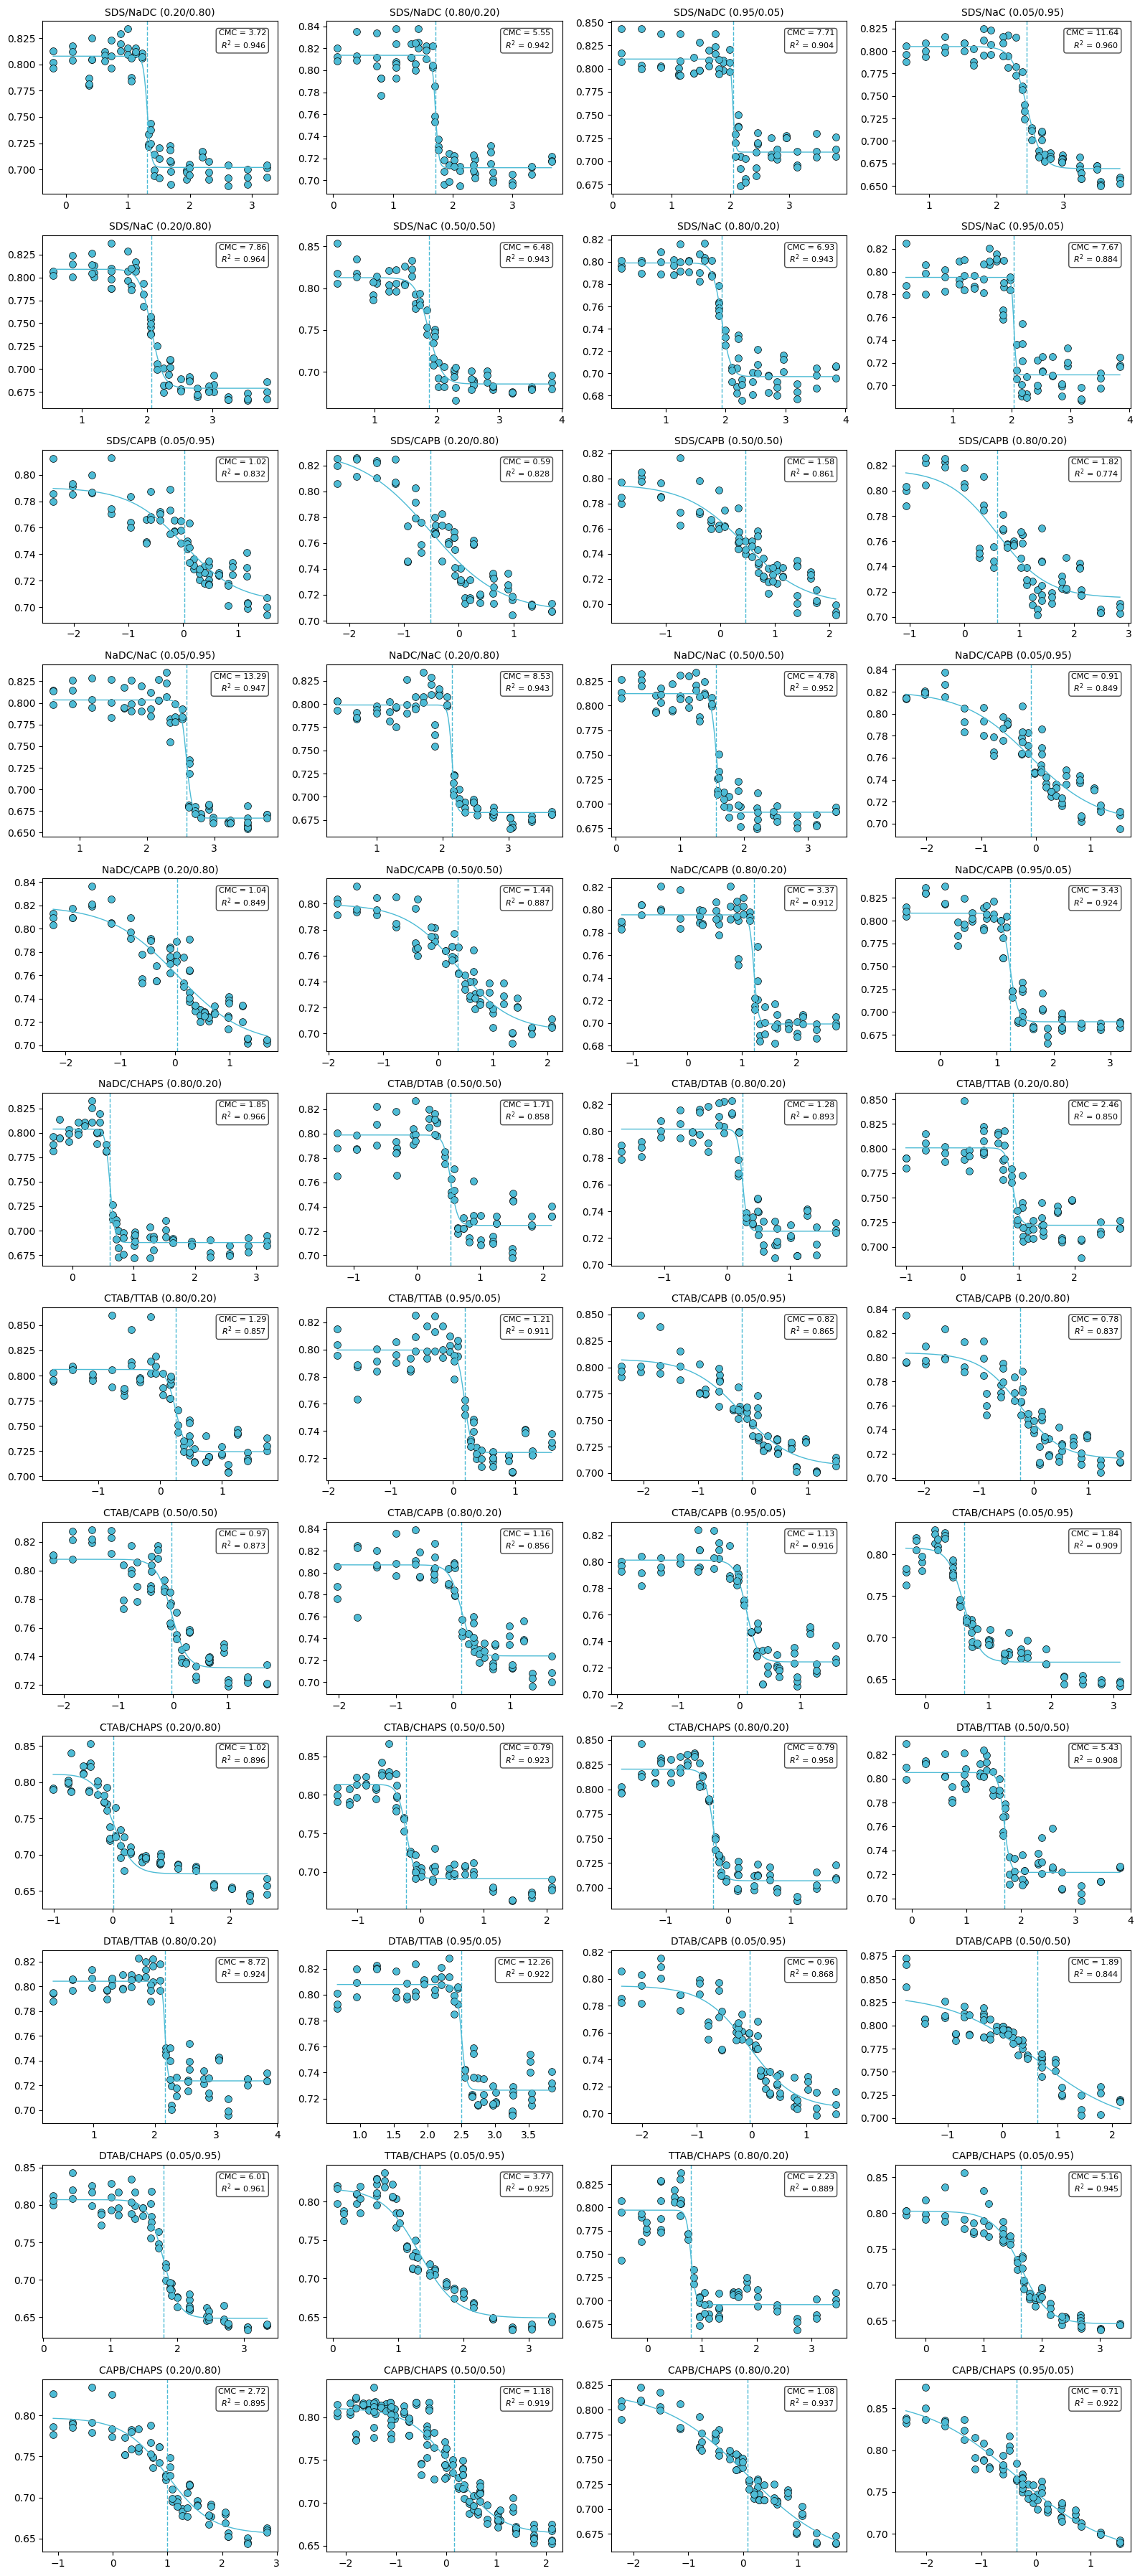

,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,CMC,R2
0,SDS,0.20,NaDC,0.80,3.717681,0.945897
1,SDS,0.80,NaDC,0.20,5.547220,0.942125
2,SDS,0.95,NaDC,0.05,7.714301,0.903838
3,SDS,0.05,NaC,0.95,11.635153,0.959706
4,SDS,0.20,NaC,0.80,7.864731,0.963597
5,SDS,0.50,NaC,0.50,6.480077,0.942744
6,SDS,0.80,NaC,0.20,6.928702,0.943350
7,SDS,0.95,NaC,0.05,7.671751,0.884364
8,SDS,0.05,CAPB,0.95,1.020730,0.831734
9,SDS,0.20,CAPB,0.80,0.594761,0.827754


In [18]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Boltzmann sigmoidal function
def boltzmann(x, A1, A2, x0, dx):
    return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))

# CMC_plot function as provided
def CMC_plot(ax, ratio, conc, log=0, plot=1):
    if log:
        conc = np.log(conc)

    p0 = [
        max(ratio),
        min(ratio),
        (max(conc) + min(conc)) / 2,
        (max(conc) - min(conc)) / 5
    ]
    popt, _ = curve_fit(boltzmann, conc, ratio, p0, maxfev=5000)
    A1, A2, x0, dx = popt

    # compute R²
    residuals = ratio - boltzmann(conc, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ratio - np.mean(ratio))**2)
    r2 = 1 - ss_res / ss_tot

    if plot:
        x_fit = np.linspace(min(conc), max(conc), 200)
        ax.scatter(
            conc,
            ratio,
            s=50,
            facecolors=blue,
            edgecolors='black',
            linewidth=0.5
        )
        ax.plot(
            x_fit,
            boltzmann(x_fit, *popt),
            color=blue,
            lw=1
        )
        ax.axvline(
            x0,
            linestyle='--',
            color=blue,
            lw=1
        )
        if log:
            x0 = math.exp(x0)
        ax.text(
            0.95, 0.95,
            f"CMC = {x0:.2f}\n$R^2$ = {r2:.3f}",
            transform=ax.transAxes, ha='right', va='top',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
        )
    return x0, r2

# Assuming `combined_full` is loaded and passed as `df`
COMBINE_ASSAYS = True

df = combined_full.copy()

# Column definitions
I1_COL = '334_373'
I3_COL = '334_384'
RATIO_COL = 'ratio'
SURF_1_COL = 'surfactant_1'
SURF_1_RATIO_COL = 'surfactant_1_ratio'
SURF_2_COL = 'surfactant_2'
SURF_2_RATIO_COL = 'surfactant_2_ratio'
ASSAY_COL = 'assay'
CONC_COL = 'concentration'

# Ensure ratio columns are numeric
df[SURF_1_RATIO_COL] = pd.to_numeric(df[SURF_1_RATIO_COL], errors='coerce')
df[SURF_2_RATIO_COL] = pd.to_numeric(df[SURF_2_RATIO_COL], errors='coerce')

# Surfactant ordering
SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']
df[SURF_1_COL] = pd.Categorical(df[SURF_1_COL], categories=SURFACTANT_ORDER, ordered=True)
df[SURF_2_COL] = pd.Categorical(df[SURF_2_COL], categories=SURFACTANT_ORDER, ordered=True)

# Identify unique surfactant combinations (including ratios)
combos = (
    df[[SURF_1_COL, SURF_2_COL, SURF_1_RATIO_COL, SURF_2_RATIO_COL]]
      .drop_duplicates()
      .sort_values([SURF_1_COL, SURF_2_COL, SURF_1_RATIO_COL])
      .reset_index(drop=True)
)

# Prepare subplots
nplots = len(combos)
ncols = 4
nrows = int(np.ceil(nplots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)

# -- NEW: prepare to collect CMC & R2 results --
results = []

# Loop through each combination
for idx, combo in combos.iterrows():
    surf1 = combo[SURF_1_COL]
    surf2 = combo[SURF_2_COL]
    # Cast ratios to float for formatting
    r1 = float(combo[SURF_1_RATIO_COL])
    r2 = float(combo[SURF_2_RATIO_COL])
    ax = axes[idx // ncols, idx % ncols]

    # Filter data for this specific combo
    sub = df[
        (df[SURF_1_COL] == surf1) &
        (df[SURF_2_COL] == surf2) &
        (df[SURF_1_RATIO_COL] == r1)
    ]
    conc = sub[CONC_COL].values
    ratio_vals = sub[RATIO_COL].values

    # Generate plot and capture CMC & R2
    cmc, r2_fit = CMC_plot(ax, ratio_vals, conc, log=1, plot=1)
    ax.set_title(f"{surf1}/{surf2} ({r1:.2f}/{r2:.2f})", fontsize=10)

    # -- NEW: append this combo's results --
    results.append({
        SURF_1_COL:       surf1,
        SURF_1_RATIO_COL: r1,
        SURF_2_COL:       surf2,
        SURF_2_RATIO_COL: r2,
        'CMC':            cmc,
        'R2':             r2_fit
    })

# Disable any unused subplots
for j in range(nplots, nrows * ncols):
    axes[j // ncols, j % ncols].axis('off')

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
#fig.savefig('Figure_4a.png', dpi=300)
results_df

In [19]:
single_cmc = pd.read_excel("Table_1.xlsx")
single_cmc

,surfactant,replicate CV,assay CV,time CV,overall CV,measured CMC,measured CMC STD,literature low,literature high
0,SDS,0.02,0.03,0.02,0.03,8.63,0.24,7.00,10.00
1,NaDC,0.01,0.01,0.01,0.02,5.50,0.09,2.48,8.20
2,NaC,0.03,0.04,0.03,0.04,14.99,0.64,13.00,15.00
3,CTAB,0.02,0.06,0.02,0.05,1.10,0.06,0.90,1.24
4,DTAB,0.03,0.03,0.04,0.04,14.87,0.65,15.70,16.00
5,TTAB,0.01,0.02,0.02,0.03,3.83,0.11,3.77,4.20
6,CAPB,-0.48,0.18,-13.27,-73.92,-0.02,1.68,0.28,0.97
7,CHAPS,0.03,0.09,0.03,0.08,6.86,0.54,6.00,10.00


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cmc_vs_surf1_ratio(results_df, single_cmc_df, ncols=5):


    s1 = 'surfactant_1'
    s2 = 'surfactant_2'
    rat = 'surfactant_1_ratio'
    cmc = 'CMC'
    surf = 'surfactant'
    meas = 'measured CMC'

    # build lookup for pure compounds
    cmc_lookup = single_cmc_df.set_index(surf)[meas].to_dict()

    # find all unique combos
    combos = results_df[[s1, s2]].drop_duplicates().reset_index(drop=True)
    nplots = len(combos)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*4, nrows*3),
                             squeeze=False)

    for idx, combo in combos.iterrows():
        surf1 = combo[s1]
        surf2 = combo[s2]
        ax = axes[idx // ncols, idx % ncols]

        # mixture data
        sub = results_df[(results_df[s1]==surf1)&(results_df[s2]==surf2)]
        x_mix = sub[rat].values
        y_mix = sub[cmc].values

        # pure endpoints
        y0 = cmc_lookup.get(surf2, np.nan)  # at ratio 0
        y1 = cmc_lookup.get(surf1, np.nan)  # at ratio 1

        # combine and sort
        x_all = np.concatenate(([0], x_mix, [1]))
        y_all = np.concatenate(([y0], y_mix, [y1]))
        order = np.argsort(x_all)
        x_all, y_all = x_all[order], y_all[order]

        # single line+marker plot
        ax.plot(
            x_all, y_all,
            linestyle='-',
            color=blue,              # line color
            marker='o',
            markersize=8,
            markerfacecolor=blue,    # fill color of the markers
            markeredgecolor='black',   # border color of the markers
            markeredgewidth=0.5,       # border width of the markers
            label=f"{surf1}/{surf2}"
        )

        ax.set_title(f"{surf1}/{surf2}", fontsize=10)
        ax.set_xlabel(f"{surf1} Ratio", fontsize=10)
        ax.set_ylabel('CMC (mM)')
#        ax.grid(True, linestyle='--', alpha=0.5)
#        ax.legend(fontsize=6, loc='best')

    # turn off any empty subplots
    for j in range(nplots, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    fig.savefig('Figure_4b.png', dpi=300)
    plt.show()


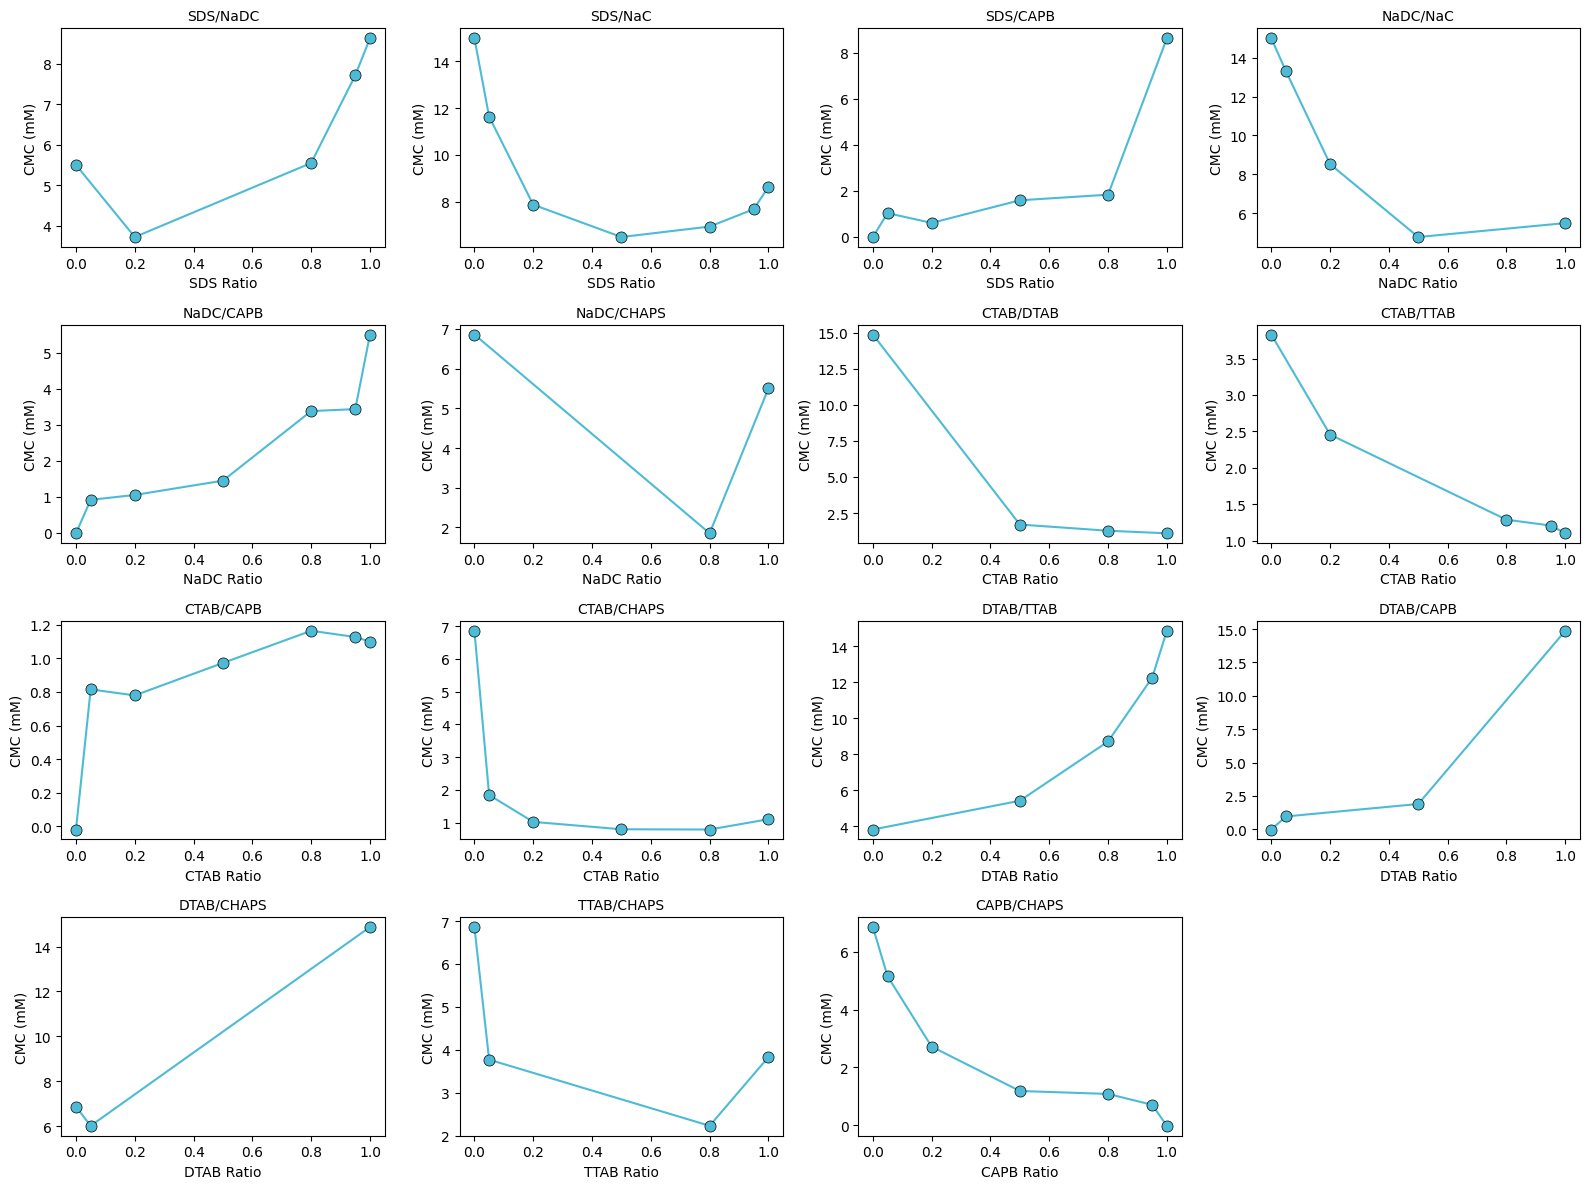

In [21]:
plot_cmc_vs_surf1_ratio(results_df, single_cmc, ncols=4)


In [22]:
results_df

,surfactant_1,surfactant_1_ratio,surfactant_2,surfactant_2_ratio,CMC,R2
0,SDS,0.20,NaDC,0.80,3.717681,0.945897
1,SDS,0.80,NaDC,0.20,5.547220,0.942125
2,SDS,0.95,NaDC,0.05,7.714301,0.903838
3,SDS,0.05,NaC,0.95,11.635153,0.959706
4,SDS,0.20,NaC,0.80,7.864731,0.963597
5,SDS,0.50,NaC,0.50,6.480077,0.942744
6,SDS,0.80,NaC,0.20,6.928702,0.943350
7,SDS,0.95,NaC,0.05,7.671751,0.884364
8,SDS,0.05,CAPB,0.95,1.020730,0.831734
9,SDS,0.20,CAPB,0.80,0.594761,0.827754
